In [ ]:
#mount google drive in colab

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#print working directory
!pwd

/content


In [11]:
import os

#init dataset
dataset_path = 'data/waterquality_clean.csv'#'/content/drive/MyDrive/dataset/WaterQuality/waterQuality1.csv'

#list directories in dataset
print(os.listdir())
#print(os.listdir('/content/drive/MyDrive/dataset/WaterQuality'))

['.ipynb_checkpoints', 'data', 'db.sqlite3', 'manage.py', 'requirements', 'requirements.txt', 'rf_classification_model.pkl', 'rf_model.sav', 'static', 'templates', 'waterQuality.ipynb', 'wqapp', 'wqpred']


In [10]:
#packages

import pickle
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomTreesEmbedding, RandomForestClassifier
from imblearn.metrics import geometric_mean_score
import matplotlib.pylab as plt
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE
from imblearn.under_sampling import EditedNearestNeighbours
import seaborn as sns

In [12]:
pip freeze

absl-py==1.2.0
aiohttp @ file:///C:/ci/aiohttp_1646806572557/work
aiosignal @ file:///tmp/build/80754af9/aiosignal_1637843061372/work
alabaster @ file:///home/ktietz/src/ci/alabaster_1611921544520/work
altair==4.2.0
anaconda-client @ file:///C:/ci/anaconda-client_1635342725944/work
anaconda-navigator==2.1.4
anaconda-project @ file:///tmp/build/80754af9/anaconda-project_1637161053845/work
anyio @ file:///C:/ci/anyio_1644481921011/work/dist
appdirs==1.4.4
argon2-cffi @ file:///opt/conda/conda-bld/argon2-cffi_1645000214183/work
argon2-cffi-bindings @ file:///C:/ci/argon2-cffi-bindings_1644551690056/work
arrow @ file:///opt/conda/conda-bld/arrow_1649166651673/work
astroid @ file:///C:/ci/astroid_1628063282661/work
astropy @ file:///C:/ci/astropy_1650634291321/work
asttokens @ file:///opt/conda/conda-bld/asttokens_1646925590279/work
astunparse==1.6.3
async-timeout @ file:///tmp/build/80754af9/async-timeout_1637851218186/work
atomicwrites==1.4.0
attrs @ file:///opt/conda/conda-bld/attrs_1642

In [18]:
#Read the data file and preview it

OrigData = pd.read_csv(dataset_path)
OrigData = OrigData.drop(labels="Unnamed: 0", axis=1)
OrigData.head()

,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,bacteria,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
0,1.65,9.08,0.04,2.85,0.007,0.35,0.83,0.17,0.05,0.20,...,0.054,16.08,1.13,0.007,37.75,6.78,0.08,0.34,0.02,1
1,2.32,21.16,0.01,3.31,0.002,5.28,0.68,0.66,0.90,0.65,...,0.100,2.01,1.93,0.003,32.26,3.21,0.08,0.27,0.05,1
2,1.01,14.02,0.04,0.58,0.008,4.24,0.53,0.02,0.99,0.05,...,0.078,14.16,1.11,0.006,50.28,7.07,0.07,0.44,0.01,0
3,1.36,11.33,0.04,2.96,0.001,7.23,0.03,1.66,1.08,0.71,...,0.016,1.41,1.29,0.004,9.12,1.72,0.02,0.45,0.05,1
4,0.92,24.33,0.03,0.20,0.006,2.67,0.69,0.57,0.61,0.13,...,0.117,6.74,1.11,0.003,16.90,2.41,0.02,0.06,0.02,1


In [44]:
median_df = OrigData.groupby("is_safe").median().T
median_df.head()

is_safe,0,1
aluminium,0.07,1.550
ammonia,14.34,12.470
arsenic,0.06,0.030
barium,1.10,1.740
cadmium,0.04,0.006


In [45]:
median_df = median_df[median_df.index.isin(["aluminium","arsenic","barium","cadmium","chloramine","chromium","perchlorate","silver","uranium","viruses"])]

In [46]:
median_df = median_df.sort_index(ascending=True)

In [47]:
median_df

is_safe,0,1
aluminium,0.070,1.550
arsenic,0.060,0.030
barium,1.100,1.740
cadmium,0.040,0.006
chloramine,0.410,3.435
chromium,0.080,0.360
perchlorate,6.785,18.160
silver,0.080,0.130
uranium,0.050,0.030
viruses,0.008,0.005


In [29]:
median_df = median_df.filter(items=["aluminum","arsenic","barium","cadmium","chloramine","chromium","perchlorate","silver","uranium","viruses"],columns = [0,1],axis=0)

TypeError: filter() got an unexpected keyword argument 'columns'

In [28]:
median_df.head()

is_safe
arsenic
barium
cadmium
chloramine
chromium


In [13]:
#Perform data exploration

OrigData.describe()

,Unnamed: 0,aluminium,ammonia,arsenic,barium,cadmium,chloramine,chromium,copper,flouride,...,lead,nitrates,nitrites,mercury,perchlorate,radium,selenium,silver,uranium,is_safe
count,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,...,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000,7996.000000
mean,3997.622811,0.666396,14.278212,0.161477,1.567928,0.042803,2.177589,0.247300,0.805940,0.771646,...,0.099431,9.819250,1.329846,0.005193,16.465266,2.920106,0.049684,0.147811,0.044672,0.114057
std,2308.592821,1.265323,8.878930,0.252632,1.216227,0.036049,2.567210,0.270663,0.653595,0.435423,...,0.058169,5.541977,0.573271,0.002967,17.688827,2.322805,0.028773,0.143569,0.026906,0.317900
min,0.000000,0.000000,-0.080000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1998.750000,0.040000,6.577500,0.030000,0.560000,0.008000,0.100000,0.050000,0.090000,0.407500,...,0.048000,5.000000,1.000000,0.003000,2.170000,0.820000,0.020000,0.040000,0.020000,0.000000
50%,3997.500000,0.070000,14.130000,0.050000,1.190000,0.040000,0.530000,0.090000,0.750000,0.770000,...,0.102000,9.930000,1.420000,0.005000,7.745000,2.410000,0.050000,0.080000,0.050000,0.000000
75%,5996.250000,0.280000,22.132500,0.100000,2.482500,0.070000,4.240000,0.440000,1.390000,1.160000,...,0.151000,14.610000,1.760000,0.008000,29.487500,4.670000,0.070000,0.240000,0.070000,0.000000
max,7998.000000,5.050000,29.840000,1.050000,4.940000,0.130000,8.680000,0.900000,2.000000,1.500000,...,0.200000,19.830000,2.930000,0.010000,60.010000,7.990000,0.100000,0.500000,0.090000,1.000000


In [14]:
#Get data info

OrigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7996 non-null   int64  
 1   aluminium    7996 non-null   float64
 2   ammonia      7996 non-null   float64
 3   arsenic      7996 non-null   float64
 4   barium       7996 non-null   float64
 5   cadmium      7996 non-null   float64
 6   chloramine   7996 non-null   float64
 7   chromium     7996 non-null   float64
 8   copper       7996 non-null   float64
 9   flouride     7996 non-null   float64
 10  bacteria     7996 non-null   float64
 11  viruses      7996 non-null   float64
 12  lead         7996 non-null   float64
 13  nitrates     7996 non-null   float64
 14  nitrites     7996 non-null   float64
 15  mercury      7996 non-null   float64
 16  perchlorate  7996 non-null   float64
 17  radium       7996 non-null   float64
 18  selenium     7996 non-null   float64
 19  silver

In [9]:
#Note: All fields are not null. However, the ammonia and is_safe features are of type object.
# To handle the non-numeric values, we can use the "to_numeric" function and convert them to Null first.
OrigData['ammonia'] = pd.to_numeric(OrigData['ammonia'], errors='coerce')

In [18]:
#Get number of row affected in ammonia column
OrigData['ammonia'].isnull().sum()

3

In [19]:
#Drop non-numeric rows found in [19] for ammonia column
OrigData.dropna(subset=['ammonia'], inplace=True)

In [20]:
#Repeat step [19] for is_safe col but not affect row is found
OrigData['is_safe'] = pd.to_numeric(OrigData['is_safe'], errors='coerce')
OrigData['is_safe'].isnull().sum()

0

In [15]:
# Recheck the dataset info after step [18-22]. Object format is now fixed
OrigData.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7996 entries, 0 to 7995
Data columns (total 22 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   7996 non-null   int64  
 1   aluminium    7996 non-null   float64
 2   ammonia      7996 non-null   float64
 3   arsenic      7996 non-null   float64
 4   barium       7996 non-null   float64
 5   cadmium      7996 non-null   float64
 6   chloramine   7996 non-null   float64
 7   chromium     7996 non-null   float64
 8   copper       7996 non-null   float64
 9   flouride     7996 non-null   float64
 10  bacteria     7996 non-null   float64
 11  viruses      7996 non-null   float64
 12  lead         7996 non-null   float64
 13  nitrates     7996 non-null   float64
 14  nitrites     7996 non-null   float64
 15  mercury      7996 non-null   float64
 16  perchlorate  7996 non-null   float64
 17  radium       7996 non-null   float64
 18  selenium     7996 non-null   float64
 19  silver

<AxesSubplot:>

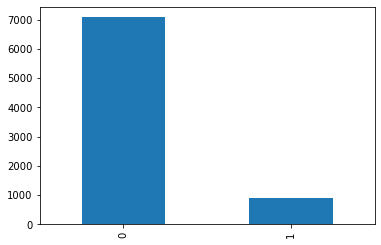

In [22]:
# Calculate the number of records in each class that is those that are unsafe and safe for drinking; this gives an idea
# if the classes are balanced or not.

OrigData['is_safe'].value_counts().plot.bar()

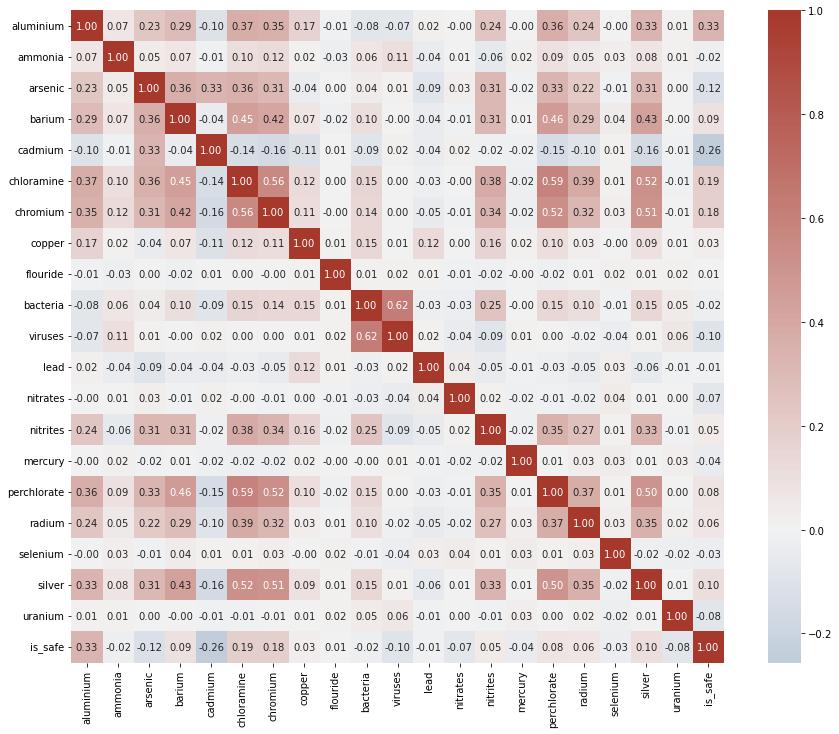

In [23]:
# Check the feature relation and their relation to the response variable
corr_mat = OrigData.corr()
plt.figure(figsize=(16,12))
# Create a custom diverging palette
cmap = sns.diverging_palette(250, 15, s=75, l=40,
                             n=9, center="light", as_cmap=True)

_ = sns.heatmap(corr_mat, center=0, annot=True,
                fmt='.2f', square=True, cmap=cmap)

C:\Users\user\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='is_safe', ylabel='Density'>

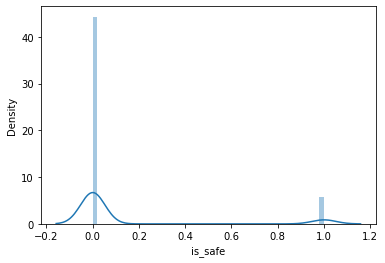

In [24]:
# Distplot of WQ is_safe parameter

sns.distplot(OrigData['is_safe'])

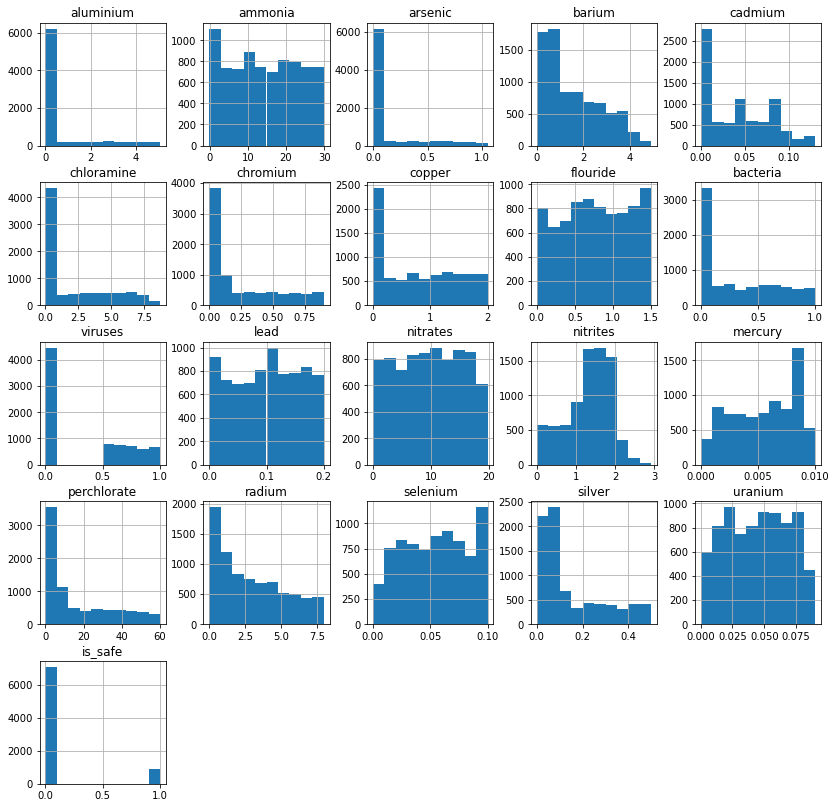

In [25]:
# Histogram of all parameter
OrigData.hist(figsize=(14,14))
plt.show()

In [26]:
# separate the feature columns from the response column and create the train, validate and test sets

y = OrigData['is_safe']
X = OrigData.drop('is_safe', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y,test_size=0.2, random_state=100)

In [27]:
RF_weighted = RandomForestClassifier(n_estimators=25, max_leaf_nodes=20, random_state=100)
RF_weighted.fit(X_train, y_train)
PredRFWeighted = RF_weighted.predict(X_test)
PredProbRFWeighted = RF_weighted.predict_proba(X_test)

In [28]:
print('The Results of the Random Forest Classifier using over-sampling')
print(metrics.classification_report(y_test, PredRFWeighted))
print('Precision: {}'.format(metrics.precision_score(y_test, PredRFWeighted)))
print('Recall: {}'.format(metrics.recall_score(y_test, PredRFWeighted)))
print('Geometric Mean Score: {}'.format(geometric_mean_score(y_test, PredRFWeighted)))

The Results of the Random Forest Classifier using over-sampling
              precision    recall  f1-score   support

           0       0.94      0.99      0.97      1418
           1       0.85      0.54      0.66       182

    accuracy                           0.94      1600
   macro avg       0.90      0.76      0.81      1600
weighted avg       0.93      0.94      0.93      1600

Precision: 0.8521739130434782
Recall: 0.5384615384615384
Geometric Mean Score: 0.7293874661177213


<AxesSubplot:>

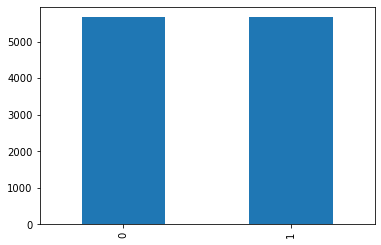

In [29]:
# # Handle class imbalance using data oversampling
# oversampling to increase the number of samples of the minority class.
# Using both Random oversampling and SMOTE oversampling.

# ros = RandomOverSampler(random_state=100) # uncomment for Random oversampling

ros = SMOTE(random_state=100) # uncomment for oversampling using SMOTE
X_train_bl, y_train_bl = ros.fit_resample(X_train, y_train)
y_train_bl.value_counts().plot.bar()

In [30]:
# # Randoming forest using oversampling

RF_no_weight = RandomForestClassifier(n_estimators=25, max_leaf_nodes=20, random_state=100)
RF_no_weight.fit(X_train_bl, y_train_bl)
PredRFOversampling = RF_no_weight.predict(X_test)
PredProbRFOversampling = RF_no_weight.predict_proba(X_test)

In [31]:
print('The Results of the Random Forest Classifier using over-sampling')
print(metrics.classification_report(y_test, PredRFOversampling))
print('Precision: {}'.format(metrics.precision_score(y_test, PredRFOversampling)))
print('Recall: {}'.format(metrics.recall_score(y_test, PredRFOversampling)))
print('Geometric Mean Score: {}'.format(geometric_mean_score(y_test, PredRFOversampling)))

The Results of the Random Forest Classifier using over-sampling
              precision    recall  f1-score   support

           0       0.97      0.93      0.95      1418
           1       0.58      0.77      0.66       182

    accuracy                           0.91      1600
   macro avg       0.78      0.85      0.81      1600
weighted avg       0.93      0.91      0.92      1600

Precision: 0.5833333333333334
Recall: 0.7692307692307693
Geometric Mean Score: 0.8455667822522036


In [6]:

# Dump pickle file of the model
print("[INFO] Saving model...")
pickle.dump(RF_weighted,open('/content/drive/MyDrive/dataset/WaterQuality/rf_classification_model.pkl', 'wb'))

[INFO] Saving model...


NameError: name 'RF_weighted' is not defined

In [7]:
#Test using pickle file
model = pickle.load(open('rf_classification_model.pkl', 'rb'))

model.predict([ [3.18, 0.15, 0.76, 4.48, 0.01, 1.05, 0.83, 0.3, 1.24, 0, 0.51, 0.098, 11.08, 1.29, 0.003, 23.53, 1.32, 0.04, 0.02, 0.05] ])

C:\Users\user\anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


array([0], dtype=int64)

In [8]:
pickle.dump(model, open('rf_model.sav','wb'))